In [1]:
import Pkg
Pkg.activate(".")
# Pkg.add([
#     "DifferentialEquations",
#     "FiniteDiff",
#     "Plots",
#     "StatsBase",
#     "Distributions",
#     "Combinatorics"
# ])
Pkg.resolve()
Pkg.instantiate()


  Activating project at `~/PhDProjects/Model/jupyter/DCM/dcm_jv`
  No Changes to `~/PhDProjects/Model/jupyter/DCM/dcm_jv/Project.toml`
  No Changes to `~/PhDProjects/Model/jupyter/DCM/dcm_jv/Manifest.toml`


In [ ]:
using OrdinaryDiffEq
using LinearAlgebra
using Distributions
using Random
using StatsBase
using Plots
using FiniteDiff


In [8]:
include("dcm.jl")
include("vb_infer.jl")
include("group_inference.jl")


run_bmr (generic function with 1 method)

# Test / Simulate

In [4]:
n = 3
t = range(0, 30, length=200)
n_subjects = 5

A = [-0.4 0.2 0.0; 0.1 -0.3 0.1; 0.0 0.2 -0.3]
B = [0.1 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
C = [0.2, 0.1, 0.0]
τ = fill(0.98, n)
α = fill(0.33, n)
e₀ = fill(0.34, n)
θ0 = vcat(vec(A), vec(B), C, τ, α)

labels = [ "A$(i)$(j)" for i in 1:n, j in 1:n ] |> vec
append!(labels, [ "B$(i)$(j)" for i in 1:n, j in 1:n ] |> vec)
append!(labels, ["C$i" for i in 1:n])
append!(labels, ["tau$i" for i in 1:n])
append!(labels, ["alpha$i" for i in 1:n])

struct ParamTemplate
    θ0::Vector{Float64}
    n_regions::Int
    use_B::Bool
end

function build_params(θ, template::ParamTemplate)
    n = template.n_regions
    offset = 0
    A = reshape(θ[offset+1:offset+n^2], n, n); offset += n^2
    B = template.use_B ? reshape(θ[offset+1:offset+n^2], n, n) : zeros(n,n); offset += template.use_B ? n^2 : 0
    C = θ[offset+1:offset+n]; offset += n
    τ = θ[offset+1:offset+n]; offset += n
    α = θ[offset+1:offset+n]
    return (; A, B, C, τ, α, e₀, n_regions=n)
end

build_params (generic function with 1 method)

In [9]:
param_template = ParamTemplate(θ0, n, true)

θs = zeros(n_subjects, length(θ0))
for i in 1:n_subjects
    params = build_params(θ0, param_template)
    y = simulate_dcm(params, t) .+ 0.01 * randn(length(t), n)
    θs[i, :] .= vb_infer(y, t, param_template)
end

μ, σ² = run_peb(θs)
best_mask = run_bmr(μ, σ², labels)

VB Iteration 1
VB Iteration 2
VB Iteration 3
VB Iteration 4
VB Iteration 5
VB Iteration 1
VB Iteration 2
VB Iteration 3
VB Iteration 4
VB Iteration 5
VB Iteration 1
VB Iteration 2
VB Iteration 3
VB Iteration 4
VB Iteration 5
VB Iteration 1
VB Iteration 2
VB Iteration 3
VB Iteration 4
VB Iteration 5
VB Iteration 1
VB Iteration 2
VB Iteration 3
VB Iteration 4
VB Iteration 5


27-element BitVector:
 0
 1
 1
 0
 1
 1
 1
 1
 0
 1
 1
 0
 1
 ⋮
 1
 1
 1
 1
 1
 1
 0
 0
 0
 0
 1
 0

In [16]:
θs[1,:]

27-element Vector{Float64}:
 -0.4014755418920954
 -0.11071478572566493
 -0.31476339835420253
  0.1945882554360001
 -0.1423160537998899
  0.26120313278559043
 -0.020342850134963078
  0.029773659928945213
 -0.4516933396035374
  0.11966319064960085
 -0.20008285761486289
  8.770354386339477
 -0.05972980279283219
  ⋮
  0.0018314672895615512
  0.010527120341368441
  1.0104588876692563e-6
 -0.48463768983938466
  0.06599576168292642
  0.06064381519626053
  0.7910341536738643
  0.8081401562527497
  0.9709957535070739
  0.3973375420988667
  0.06514162494152038
  0.143174724757352

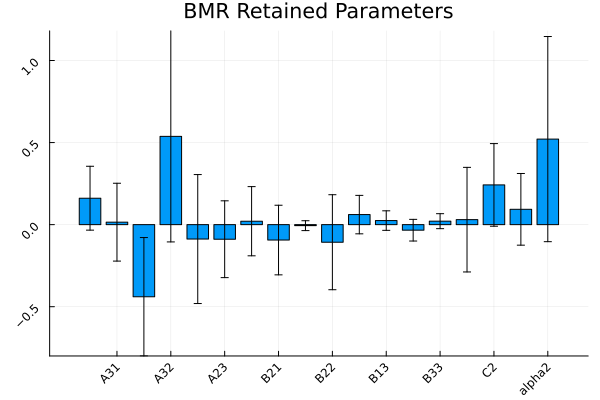

In [12]:
# PEB Plot
bar(labels, μ[:], yerror=sqrt.(σ²)[:], legend=false, title="PEB Posterior Means", rotation=45)
# BMR Plot
bar(labels[best_mask], μ[best_mask], yerror=sqrt.(σ²)[best_mask], legend=false, title="BMR Retained Parameters", rotation=45)

In [13]:
μ

1×27 Matrix{Float64}:
 -0.56362  0.161042  0.0150076  0.217152  …  0.323783  0.521208  1.11217

In [14]:
σ² 

1×27 Matrix{Float64}:
 0.15317  0.0378675  0.0562471  0.000694303  …  0.00421708  0.390656  2.62173

# Real data

In [17]:
### FORMAT

# Y_subj = [y1, y2, ..., y5], each a (T, R) matrix of fMRI signals
# task_input = [0, 0, 1, 1, ..., 0]



In [18]:
TR = 1.55

1.55

In [ ]:
function make_input_function(task::Vector{Float64}, tvec::Vector{Float64})
    return t -> task[clamp(findlast(x -> x ≤ t, tvec), 1, length(task))]
end